In [1]:
# !pip install roboflow supervision
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
from roboflow import Roboflow
import supervision as sv
import cv2
import numpy as np
from typing import List
import matplotlib.pyplot as plt


rf = Roboflow(api_key="FvqF3j07aqqT0BqM0VjB")
project = rf.workspace().project("waste-in-water")
model = project.version(1).model

loading Roboflow workspace...
loading Roboflow project...


In [3]:
path = "../data/Dataset/test/"
filename = "test_image100"

result = model.predict(path+filename+".JPG", confidence=20, overlap=30).json()

In [5]:
import json
from create_feature_vectors import Rectangle

# get trash labeled rectangles from json file
true_rectangles = []

with open(path + filename + ".json") as json_file:
    data = json.load(json_file)
    shapes = data["shapes"]

    for shape in shapes:
        if shape["shape_type"] != "rectangle":
            raise Exception("Invalid shape type in", filename)
        if shape["label"] != "trash":
            raise Exception("Invalid label in", filename)

        p1, p2 = shape["points"]
        p1 = tuple(map(int, p1))
        p2 = tuple(map(int, p2))
        print(p1, p2)
        
        true_rectangles.append(Rectangle(x_l=min(p1[0], p2[0]), y_b=min(p1[1], p2[1]), x_r=max(p1[0], p2[0]), y_t=max(p1[1], p2[1])))
        # true_rectangles.append(Rectangle(x_l=bl[0], y_b=bl[1], x_r=tr[0], y_t=tr[1]))


# get predicted rectangles from the result
predicted_rectangles = []
predicted_confidences = []

for item in result["predictions"]:
    if item["class"] != "Plastic Bottle":
        print(f"Detected other object: {item['class']}")
    else:
        predicted_rectangles.append(Rectangle(x_l=item["x"], y_b=item["y"], x_r=item["x"]+item["width"], y_t=item["y"]+item["height"]))
        predicted_confidences.append(item["confidence"])

(1513, 333) (1384, 500)


In [6]:
merged_rectangles = merge_rectangles(predicted_rectangles, predicted_confidences)

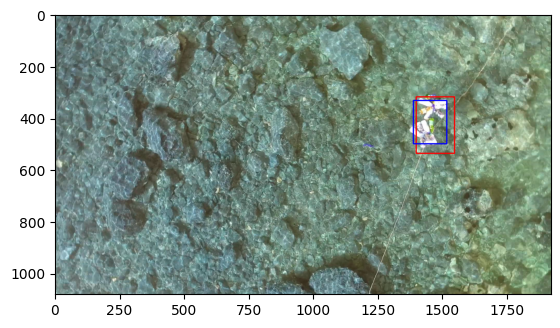

In [7]:
def draw_rectangles(image, rectangles: List[Rectangle], color=(0, 255, 0)):
    for rectangle in rectangles:
        cv2.rectangle(
            image,
            (rectangle.x_l, rectangle.y_b),
            (rectangle.x_r, rectangle.y_t),
            color,
            3,
        )
    return image

image = cv2.imread(path + filename + ".JPG")
# image = draw_rectangles(image, predicted_rectangles, color=(0, 255, 0))
image = draw_rectangles(image, merged_rectangles[0], color=(255, 0, 0))
image = draw_rectangles(image, true_rectangles, color=(0, 0, 255))

plt.imshow(image)


In [8]:
def iou_rectangles(rect1: Rectangle, rect2: Rectangle):
    x_left = max(rect1.x_l, rect2.x_l)
    x_right = min(rect1.x_r, rect2.x_r)
    y_bottom = max(rect1.y_b, rect2.y_b)
    y_top = min(rect1.y_t, rect2.y_t)

    intersection = max(0, x_right - x_left) * max(0, y_top - y_bottom)

    area1 = (rect1.x_r - rect1.x_l) * (rect1.y_t - rect1.y_b)
    area2 = (rect2.x_r - rect2.x_l) * (rect2.y_t - rect2.y_b)

    union = area1 + area2 - intersection
    return intersection / union

In [9]:
def calculate_ap50(true_rectangles, predicted_rectangles, predicted_confidences, iou_threshold=0.5):
    """
    Calculate the precision for a given IoU threshold. Rectangles should be from the same class.
    @param true_rectangles: List of true rectangles
    @param predicted_rectangles: List of predicted rectangles
    @param predicted_confidences: List of predicted confidences
    @param iou_threshold: IoU threshold
    """

    # Sort predicted rectangles by confidence score
    sorted_indices = np.argsort(predicted_confidences)[::-1]
    predicted_rectangles = [predicted_rectangles[i] for i in sorted_indices]
    print(f"{predicted_rectangles=}")

    total_true_rectangles = len(true_rectangles)
    true_positives = np.zeros(len(predicted_rectangles))
    false_positives = np.zeros(len(predicted_rectangles))

    for d, pred_rect in enumerate(predicted_rectangles):
        for t, true_rect in enumerate(true_rectangles):
            iou = iou_rectangles(pred_rect, true_rect)
            print(f"{iou=}")
            if iou >= iou_threshold and not true_positives[d]:
                true_positives[d] = 1
            else:
                false_positives[d] = 1

    cumulative_true_positives = np.cumsum(true_positives)
    cumulative_false_positives = np.cumsum(false_positives)
    precision = cumulative_true_positives / (cumulative_true_positives + cumulative_false_positives)
    # recall = cumulative_true_positives / total_true_rectangles

    return precision

ap50 = calculate_ap50(true_rectangles, merged_rectangles[0], merged_rectangles[1], iou_threshold=0.5)
ap50

predicted_rectangles=[Rectangle(x_l=1395, y_b=319, x_r=1543, y_t=537)]
iou=0.5778716166681329


array([1.])

SupervisionWarnings: from_roboflow is deprecated: `Detections.from_roboflow` is deprecated and will be removed in `supervision-0.22.0`. Use `Detections.from_inference` instead.
SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


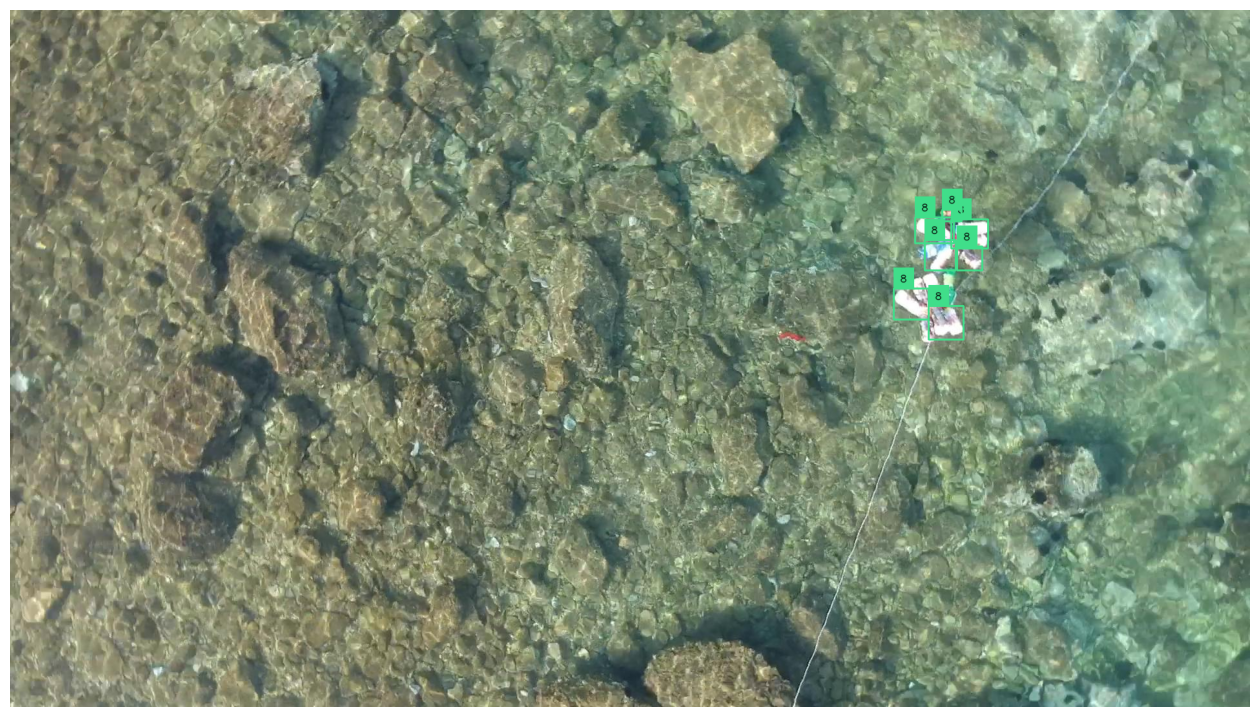

In [11]:
# show labels and bboxes from roboflow
labels = [item["class"] for item in result["predictions"]]
detections = sv.Detections.from_roboflow(result)

label_annotator = sv.LabelAnnotator()
bounding_box_annotator = sv.BoxAnnotator()

image = cv2.imread("../data/Dataset/test/test_image100.JPG")

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
# annotated_image = label_annotator.annotate(
#     scene=annotated_image, detections=detections, labels=labels)

sv.plot_image(image=annotated_image, size=(16, 16))

In [12]:
import numpy as np
predictions = list(zip(detections.xyxy, detections.confidence, detections.class_id))
predictions = np.array([(*prediction[0], prediction[1], prediction[2]) for prediction in predictions])
    

# predictions, detections
sv.box_non_max_suppression(predictions, iou_threshold=0.01)

array([ True, False, False,  True,  True,  True, False])

In [13]:
import os
import json

directory = '../data/Dataset/test'

jpg_files = [directory+"/"+file for file in os.listdir(directory) if file.endswith('.JPG')]
json_files = [file.split('.')[0] + '.json' for file in jpg_files]

for json_file, jpg_file in zip(json_files, jpg_files):
    print(json_file, jpg_file)

    result = model.predict(jpg_file, confidence=20, overlap=30).json()

    with open(json_file, 'r') as file:
      data = json.load(file)


.json ../data/Dataset/test/test_image1.JPG


FileNotFoundError: [Errno 2] No such file or directory: '.json'

In [14]:
[el["points"] for el in data["shapes"]]#[0]["points"]

[[[1513.3858267716535, 333.8582677165354], [1384.251968503937, 500.0]]]

In [15]:
[[p["x"], p["y"], p["x"]+p["width"], p["y"]+p["height"] ]for p in result["predictions"]]

[]

In [16]:
result["predictions"]

[]